# 🎯 LightGBM 금연 성공 예측 모델

**작성자:** vfxpedia  
**데이터:** prep_data_v2.csv (83 columns)  
**목표:** 전체 Feature를 활용한 금연 성공 예측 모델 구축

---

## 📋 구성

1. 환경 설정 및 데이터 로드
2. 데이터 확인 및 전처리 상태 점검
3. 데이터 분리 (Train/Validation/Test)
4. LightGBM Baseline 모델
5. Feature Importance 분석 (전체 Feature)
6. 하이퍼파라미터 튜닝
7. 최종 모델 성능 평가
8. SHAP 값 분석 (선택)

---
## 1️⃣ 환경 설정


In [32]:
# 라이브러리
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 모델 관련
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import lightgbm as lgb


# 한글 폰트
import matplotlib.font_manager as fm
try:
    font_path = r'C:\Windows\Fonts\HMFMMUEX.TTC'
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rc('font', family=font_name)
except:
    plt.rcParams['font.family'] = 'Malgun Gothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (14, 8)

# 환경설정
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)      # 행 전체 표시
pd.set_option('display.max_columns', None)  # 열 전체 표시
pd.set_option('display.width', None)        # 가로폭 자동 맞춤
pd.set_option('display.max_colwidth', None) # 셀 안의 텍스트 생략 방지
pd.set_option('display.float_format', '{:.6f}'.format)

# 경로 설정
ROOT_DIR = Path("").resolve().parent.parent.parent

# 데이터 경로
DATA_DIR = ROOT_DIR / "data"
RAW_PATH = DATA_DIR / "raw_data.csv"
DATA_PATH = DATA_DIR / "prep_data_v2.csv"


# JSON 컬럼 관리 파일 로드
JSON_PATH = ROOT_DIR / "notebooks" / "team" / "columns.json"
with open(JSON_PATH, "r", encoding="utf-8") as f:
    columns_dict = json.load(f)

print('✅ 환경 설정 완료')

def rename_to_kor(df):
    """columns.json의 name으로 한글 컬럼명 매핑"""
    rename_map = {
        col: meta["name"]
        for cat in columns_dict.values()
        for col, meta in cat.items()
        if col in df.columns
    }
    return df.rename(columns=rename_map)


✅ 환경 설정 완료


### 📂 데이터 로드


In [33]:
# 데이터 로드
from pathlib import Path

# ⚠️ model 폴더 depth: vfxpedia/model → 3단계 위로 root
ROOT_DIR = Path('').resolve().parent.parent.parent
DATA_DIR = ROOT_DIR / 'data'
DATA_PATH = DATA_DIR / 'prep_data_v2.csv'

df = pd.read_csv(DATA_PATH)

print(f"데이터 규모: {df.shape}")
print(f"\n타겟 변수 분포:")
print(df['churn'].value_counts())
print(f"\n성공률: {df['churn'].mean():.2%}")
df.head()


데이터 규모: (89822, 83)

타겟 변수 분포:
churn
1    47865
0    41957
Name: count, dtype: int64

성공률: 53.29%


,exmprs_no,age,sex,CTPRVN_CODE,SPOT_NO,wt_p,mbhld_co,reside_adult_co,fma_04z1,fma_24z2,nue_01z1,churn,nuc_02z1,nuc_03z1,dra_01z1,drb_01z3,drb_03z1,drb_04z1,drb_05z1,drg_01z3,pha_04z1,pha_05z1,pha_06z1,pha_07z1,phb_01z1,pha_11z1,mta_01z1,mta_02z1,edit_mtc_03z1,mtc_08z1,mtc_12c1,mtc_12h1,mtj_05z2,mtj_10z1,mtj_11z1,smf_01z1,sma_01z1,smb_02z1,smb_04z1,smb_05z1,smb_09z1,sma_36z1,smb_11z1,smb_12z1,smb_13z1,sma_08z1,sma_11z2,smd_02z3,smd_01z3,smc_08z2,smc_09z2,smc_10z2,sob_02z1,age_group,is_single,house_income,house_income_log,house_income_grp,fma_dementia_case,smoke_avg_per_day,education_group,is_economically_active,occupation_type,is_employee,weight_control_method,activity_score_weight,activity_score,breakfast_freq_cat,breakfast_freq_score,nutrition_awareness_bin,nutrition_interest_bin,obb_02a1_bin,obb_02b1_bin,obb_02d1_bin,healthy_method_ratio,dental_visit_barrier_cat,brush_after_lunch_cat,brush_after_lunch_bin,brush_impossible_evening_cat,oral_hygiene_barrier_cat,subjective_oral_health_cat,dental_discomfort_cat,marital_stability
0,2024111170001700102002201,31.000000,1,11,102,380.470750,1.000000,1.000000,3.000000,NaN,1.000000,1,2.000000,NaN,1.000000,5.000000,3.000000,3.000000,NaN,1.000000,2.000000,1.000000,0.000000,2.000000,5.000000,3.000000,2.000000,2.000000,0.000000,NaN,4.000000,2.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,2.000000,0.000000,3.000000,2.000000,NaN,NaN,NaN,2.000000,NaN,8.000000,NaN,2.000000,NaN,2.000000,1.000000,30.000000,1,1000.000000,6.908755,8.000000,3.000000,1.000000,2.000000,1,화이트칼라,1,1.0-2.0-2.0,11.000000,high_activity,거의안함,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.500000,Unknown,예,1.000000,예,Unknown,보통,전혀불편X,불안정
1,2024111170001700102005901,37.000000,1,11,102,380.470750,3.000000,2.000000,3.000000,NaN,1.000000,0,1.000000,1.000000,1.000000,4.000000,4.000000,3.000000,NaN,1.000000,3.000000,1.000000,0.000000,1.000000,7.000000,1.000000,4.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,4.000000,2.000000,NaN,2.000000,1.000000,30.000000,0,300.000000,5.707110,5.000000,3.000000,15.000000,2.000000,1,블루칼라,1,no_response-no_response-no_response,16.000000,high_activity,주3~4회,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.500000,Unknown,아니요,0.000000,예,시간부족,좋음,전혀불편X,안정
2,2024111170001700102005902,36.000000,2,11,102,376.403830,3.000000,2.000000,3.000000,NaN,1.000000,1,2.000000,NaN,1.000000,5.000000,4.000000,NaN,4.000000,2.000000,0.000000,88.000000,88.000000,4.000000,7.000000,1.000000,2.000000,2.000000,1.000000,NaN,3.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,NaN,5.000000,0.000000,3.000000,2.000000,NaN,NaN,NaN,2.000000,NaN,8.000000,NaN,2.000000,NaN,2.000000,1.000000,30.000000,0,300.000000,5.707110,5.000000,3.000000,10.000000,2.000000,1,블루칼라,1,2.0-2.0-2.0,183.000000,high_activity,거의안함,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,Unknown,예,1.000000,예,Unknown,좋음,전혀불편X,안정
3,2024111170001700102017001,36.000000,1,11,102,380.470750,2.000000,2.000000,3.000000,NaN,1.000000,0,1.000000,NaN,1.000000,4.000000,4.000000,3.000000,NaN,1.000000,0.000000,88.000000,88.000000,3.000000,5.000000,1.000000,2.000000,2.000000,0.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,2.000000,2.000000,NaN,2.000000,1.000000,30.000000,0,667.000000,6.504288,8.000000,3.000000,10.000000,2.000000,1,화이트칼라,1,1.0-2.0-2.0,181.000000,high_activity,거의안함,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.500000,Unknown,아니요,0.000000,예,시간부족,나쁨,그저그렇다,안정
4,2024111170001700191001801,64.000000,1,11,191,119.450590,1.000000,1.000000,1.000000,NaN,4.000000,0,2.000000,NaN,1.000000,4.000000,5.000000,4.000000,NaN,1.000000,0.000000,88.000000,88.000000,0.000000,0.000000,1.000000,1.000000,1.000000,22.000000,6.000000,4.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,2.000000,NaN,2.000000,4.000000,2.000000,NaN,3.000000,3.000000,60.000000,1,50.000000

---
## 2️⃣ 데이터 확인


In [ ]:
# 컬럼 확인
print("=" * 70)
print("📊 데이터 정보")
print("=" * 70)
print(f"\n전체 컬럼 수: {len(df.columns)}개")
print(f"전체 인원: {len(df):,}명")

# 전체 팀 파생 변수 목록 (학습에 사용되는 것만)
all_team_derived = [
    # 교육/경제/혼인 (5개)
    'education_group', 'is_economically_active', 
    'occupation_type', 'is_employee', 'marital_stability',
    # KSH: 가구/소득/연령/치매 (6개 - smoke_avg_per_day 제외)
    'age_group', 'is_single', 'house_income', 'house_income_log', 
    'house_income_grp', 'fma_dementia_case',
    # PDY: 체중/신체활동 (3개)
    'weight_control_method', 'activity_score_weight', 'activity_score',
    # Sangmin: 식생활/비만/구강 (16개)
    'breakfast_freq_cat', 'breakfast_freq_score', 'nutrition_awareness_bin',
    'nutrition_usage_bin', 'nutrition_interest_bin', 'height_m', 'oba_bmi',
    'body_perception_cat', 'weight_control_attempt_cat', 'healthy_method_ratio',
    'dental_visit_barrier_cat', 'brush_after_lunch_cat', 'brush_after_lunch_bin',
    'brush_impossible_evening_cat', 'brush_impossible_evening_bin',
    'oral_hygiene_barrier_cat', 'subjective_oral_health_cat', 'dental_discomfort_cat'
]

# 파생 변수 존재 확인
print(f"\n✅ 전체 팀 파생 변수 (학습 사용):")
existing_derived = [f for f in all_team_derived if f in df.columns]
missing_derived = [f for f in all_team_derived if f not in df.columns]

print(f"   - 총 {len(all_team_derived)}개 중 {len(existing_derived)}개 존재")
print(f"\n   📊 카테고리별:")
print(f"      • 교육/경제/혼인: 5개")
print(f"      • 가구/소득/연령: 6개")
print(f"      • 체중/신체활동: 3개")
print(f"      • 식생활/비만/구강: 16개")

print(f"\n   ⚠️ 타겟 누수로 제외: smoke_avg_per_day (일평균흡연량)")

if missing_derived:
    print(f"\n   ⚠️ 누락된 변수: {len(missing_derived)}개")
    for feat in missing_derived[:5]:  # 최대 5개만 표시
        print(f"      - {feat}")

# 결측치 확인
missing_pct = df.isnull().sum() / len(df) * 100
print(f"\n📈 결측치 통계:")
print(f"   전체 평균: {missing_pct.mean():.2f}%")
print(f"   결측 있는 컬럼: {(missing_pct > 0).sum()}개")

print("\n" + "=" * 70)


📊 데이터 정보

전체 컬럼 수: 83개
전체 인원: 89,822명

✅ 주요 파생 변수 (교육/경제/혼인 - 5개):
   ✓ education_group: 3개 카테고리
   ✓ is_economically_active: 2개 카테고리
   ✓ occupation_type: 2개 카테고리
   ✓ is_employee: 2개 카테고리
   ✓ marital_stability: 3개 카테고리

📊 전체 팀 파생 변수: 22개

📈 결측치 통계:
   전체 평균: 15.96%
   결측 있는 컬럼: 43개



---
## 3️⃣ 데이터 분리


In [ ]:
# X, y 분리
# ⚠️ 타겟 누수 변수 제거
leak_cols = [
    'sma_03z2', 'sma_12z2', 'sma_37z1',  # 타겟 생성 변수
    'sma_36z1',  # ⚠️ 궐련형전자담배평생사용 (타겟과 거의 완벽한 상관관계)
    'smoke_avg_per_day',  # ⚠️ 일평균흡연량 (NaN=금연성공, 양수=금연실패 → 타겟 누수!)
    'smd_02z3', 'smd_01z3',  # 금연 시도
    'smc_08z2', 'smc_09z2', 'smc_10z2',  # 금연 관련
    'smb_02z1', 'smb_04z1', 'smb_05z1', 'smb_09z1',  # 현재 흡연량
    'smb_11z1', 'smb_12z1', 'smb_13z1',
    'sma_08z1', 'sma_11z2',  # 액상형
    'sma_01z1',  # 흡연 경험
    'smf_01z1',  # 흡연 시작 연령
    'wt_p'  # 가중치
]

X = df.drop(['churn', 'exmprs_no'] + leak_cols, axis=1, errors='ignore')
y = df['churn']

print(f"✅ 제거된 누수 변수: {len([c for c in leak_cols if c in df.columns])}개")
print(f"✅ 최종 Feature 개수: {X.shape[1]}개")

# object → category 변환
obj_cols = X.select_dtypes(include=['object']).columns
X[obj_cols] = X[obj_cols].apply(lambda s: s.astype('category'))

# Train/Test 분리 (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train을 Train/Validation으로 분리 (64:16)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("=" * 70)
print("📊 데이터 분리 결과")
print("=" * 70)
print(f"\nTrain Set:      {X_train.shape[0]:,}명 ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation Set: {X_val.shape[0]:,}명 ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test Set:       {X_test.shape[0]:,}명 ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"\nFeature 개수: {X_train.shape[1]}개")

# 타겟 분포 확인
print(f"\n타겟 분포 (Train): {y_train.value_counts(normalize=True).to_dict()}")
print(f"타겟 분포 (Test):  {y_test.value_counts(normalize=True).to_dict()}")
print("=" * 70)


✅ 제거된 누수 변수: 18개
✅ 최종 Feature 개수: 63개
📊 데이터 분리 결과

Train Set:      57,485명 (64.0%)
Validation Set: 14,372명 (16.0%)
Test Set:       17,965명 (20.0%)

Feature 개수: 63개

타겟 분포 (Train): {1: 0.5328868400452292, 0: 0.4671131599547708}
타겟 분포 (Test):  {1: 0.5328694684107987, 0: 0.4671305315892012}


---
## 4️⃣ LightGBM Baseline 모델


In [36]:
# LightGBM 파라미터
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
    'class_weight': 'balanced'  # ⚠️ 불균형 처리
}

# 데이터셋 준비
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# 모델 학습
print("\n🚀 LightGBM Baseline 학습 중...\n")
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)

print(f"\n✅ 학습 완료! Best iteration: {model.best_iteration}")



🚀 LightGBM Baseline 학습 중...

Training until validation scores don't improve for 50 rounds
[50]	train's binary_logloss: 0.556331	valid's binary_logloss: 0.567278
[100]	train's binary_logloss: 0.532179	valid's binary_logloss: 0.55266
[150]	train's binary_logloss: 0.519968	valid's binary_logloss: 0.548912
[200]	train's binary_logloss: 0.510793	valid's binary_logloss: 0.548117
[250]	train's binary_logloss: 0.502991	valid's binary_logloss: 0.547471
[300]	train's binary_logloss: 0.495434	valid's binary_logloss: 0.547262
[350]	train's binary_logloss: 0.488429	valid's binary_logloss: 0.547541
Early stopping, best iteration is:
[306]	train's binary_logloss: 0.494473	valid's binary_logloss: 0.547258

✅ 학습 완료! Best iteration: 306


### 📊 Baseline 모델 성능


📊 Baseline 모델 성능 평가

📈 Train Set:
   - Accuracy: 0.7575

📉 Test Set:
   - Accuracy:  0.7215
   - ROC-AUC:   0.7978
   - Precision: 0.7356
   - Recall:    0.7452
   - F1-Score:  0.7404

⚠️ 과적합 체크:
   Train - Test 차이: 0.0360
   ⚡ 약간의 과적합 (차이 > 0.02)


📊 혼동 행렬 상세:
   TN (True Negative):  5,828명
   FP (False Positive): 2,564명
   FN (False Negative): 2,439명
   TP (True Positive):  7,134명


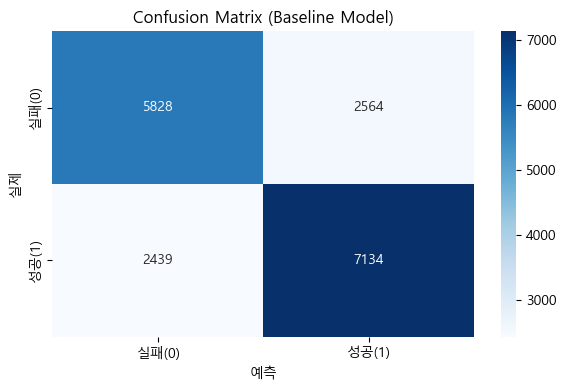

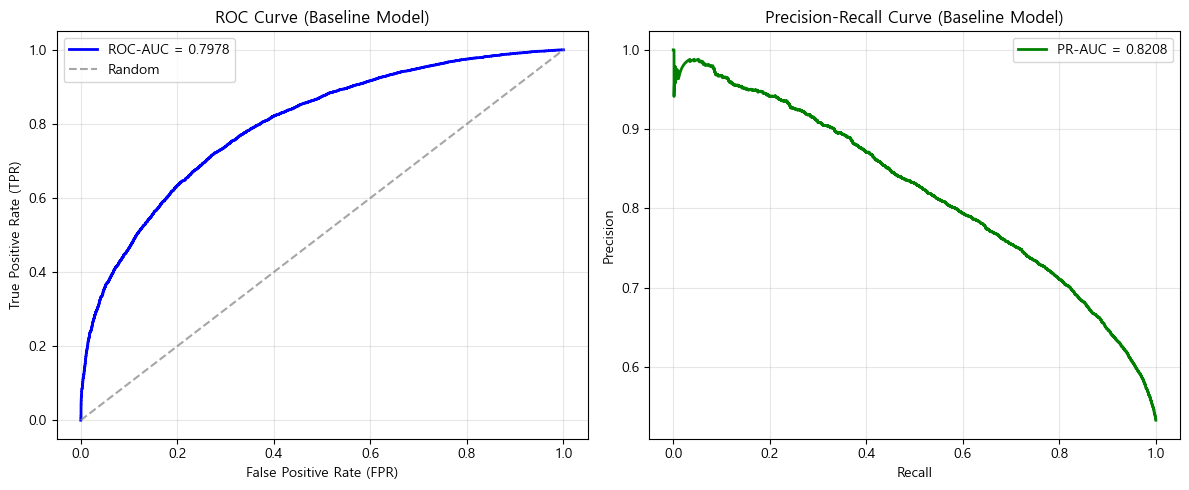


TN: 5,828 | FP: 2,564
FN: 2,439 | TP: 7,134


In [37]:
# 예측 (Train & Test)
y_pred_train = model.predict(X_train)
y_pred_train_class = (y_pred_train > 0.5).astype(int)

y_pred_test = model.predict(X_test)
y_pred_test_class = (y_pred_test > 0.5).astype(int)

# 성능 지표 계산
train_acc = accuracy_score(y_train, y_pred_train_class)
test_acc = accuracy_score(y_test, y_pred_test_class)
test_auc = roc_auc_score(y_test, y_pred_test)
test_prec = precision_score(y_test, y_pred_test_class)
test_rec = recall_score(y_test, y_pred_test_class)
test_f1 = f1_score(y_test, y_pred_test_class)

# 성능 지표 출력
print("=" * 70)
print("📊 Baseline 모델 성능 평가")
print("=" * 70)

print(f"\n📈 Train Set:")
print(f"   - Accuracy: {train_acc:.4f}")

print(f"\n📉 Test Set:")
print(f"   - Accuracy:  {test_acc:.4f}")
print(f"   - ROC-AUC:   {test_auc:.4f}")
print(f"   - Precision: {test_prec:.4f}")
print(f"   - Recall:    {test_rec:.4f}")
print(f"   - F1-Score:  {test_f1:.4f}")

# 과적합 체크
diff = train_acc - test_acc
print(f"\n⚠️ 과적합 체크:")
print(f"   Train - Test 차이: {diff:.4f}")
if diff > 0.05:
    print("   ⚠️ 과적합 가능성 있음! (차이 > 0.05)")
elif diff > 0.02:
    print("   ⚡ 약간의 과적합 (차이 > 0.02)")
else:
    print("   ✅ 과적합 없음 (차이 ≤ 0.02)")

print("\n" + "=" * 70)

# Confusion Matrix 상세 출력
cm = confusion_matrix(y_test, y_pred_test_class)
tn, fp, fn, tp = cm.ravel()
print("\n📊 혼동 행렬 상세:")
print(f"   TN (True Negative):  {tn:,}명")
print(f"   FP (False Positive): {fp:,}명")
print(f"   FN (False Negative): {fn:,}명")
print(f"   TP (True Positive):  {tp:,}명")
print("=" * 70)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['실패(0)', '성공(1)'],
            yticklabels=['실패(0)', '성공(1)'])
plt.title('Confusion Matrix (Baseline Model)')
plt.xlabel('예측')
plt.ylabel('실제')
plt.tight_layout()
plt.show()

# ROC Curve & PR Curve 시각화
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

fpr, tpr, _ = roc_curve(y_test, y_pred_test)
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_pred_test)
pr_auc = average_precision_score(y_test, y_pred_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
axes[0].plot(fpr, tpr, label=f"ROC-AUC = {test_auc:.4f}", linewidth=2, color='blue')
axes[0].plot([0, 1], [0, 1], '--', color='gray', label='Random', alpha=0.7)
axes[0].set_xlabel("False Positive Rate (FPR)")
axes[0].set_ylabel("True Positive Rate (TPR)")
axes[0].set_title("ROC Curve (Baseline Model)")
axes[0].legend()
axes[0].grid(alpha=0.3)

# PR Curve
axes[1].plot(rec_curve, prec_curve, label=f"PR-AUC = {pr_auc:.4f}", linewidth=2, color='green')
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve (Baseline Model)")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTN: {cm[0,0]:,} | FP: {cm[0,1]:,}")
print(f"FN: {cm[1,0]:,} | TP: {cm[1,1]:,}")


---
## 5️⃣ Feature Importance 분석


In [38]:
# Feature Importance 추출
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("=" * 70)
print("📊 Feature Importance Top 30")
print("=" * 70)
print(importance_df.head(30).to_string(index=False))
print("\n" + "=" * 70)


📊 Feature Importance Top 30
                   feature   importance
                       age 46722.285181
         smoke_avg_per_day 27867.249695
         marital_stability 11505.865851
                 age_group  9900.180978
      breakfast_freq_score  9346.625914
                  drb_03z1  8317.045229
     weight_control_method  8080.359882
              house_income  5498.582637
                   SPOT_NO  5202.277938
                  drb_04z1  5042.788630
             edit_mtc_03z1  4235.105872
                  mtc_12c1  4004.861439
                  dra_01z1  3755.810479
subjective_oral_health_cat  3314.183631
                  drb_01z3  3270.541730
                  pha_11z1  3220.217155
                  drg_01z3  2653.416606
                  mtc_08z1  2096.758630
                  mta_01z1  1990.542971
     activity_score_weight  1764.584371
               CTPRVN_CODE  1753.221018
                  mbhld_co  1559.337189
           occupation_type  1528.214034
     brush_a

### 📊 Feature Importance 시각화


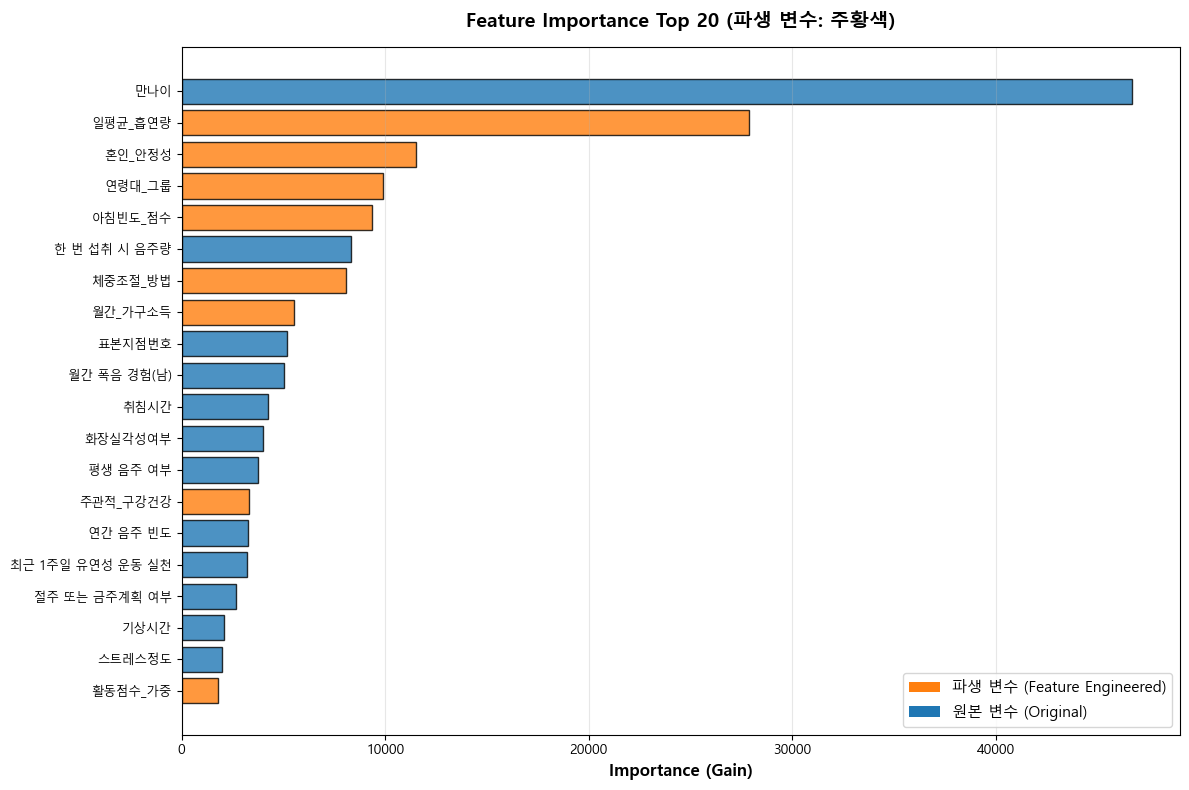

In [ ]:
# 한글 변수명 매핑 (모든 팀원의 파생 변수 포함)
# ⚠️ smoke_avg_per_day는 타겟 누수로 제외됨
derived_korean_names = {
    # === 교육/경제/혼인 파생변수 (5개) ===
    'education_group': '교육수준_그룹',
    'is_economically_active': '경제활동_여부',
    'occupation_type': '직업_유형',
    'is_employee': '근로자_여부',
    'marital_stability': '혼인_안정성',
    
    # === KSH: 가구/소득/연령/치매 (6개) ===
    'age_group': '연령대_그룹',
    'is_single': '1인가구_여부',
    'house_income': '월간_가구소득',
    'house_income_log': '로그_가구소득',
    'house_income_grp': '소득_그룹',
    'fma_dementia_case': '치매가족_여부',
    # 'smoke_avg_per_day': '일평균_흡연량',  ← 타겟 누수로 제거!
    
    # === PDY: 체중/신체활동 (3개) ===
    'weight_control_method': '체중조절_방법',
    'activity_score_weight': '활동점수_가중',
    'activity_score': '활동_수준',
    
    # === Sangmin: 식생활/비만/구강 (16개) ===
    # 식생활 (5개)
    'breakfast_freq_cat': '아침빈도_범주',
    'breakfast_freq_score': '아침빈도_점수',
    'nutrition_awareness_bin': '영양표시_인지',
    'nutrition_usage_bin': '영양표시_활용',
    'nutrition_interest_bin': '영양표시_관심',
    # 비만/체중 (5개)
    'height_m': '신장_m',
    'oba_bmi': 'BMI',
    'body_perception_cat': '체형_인지',
    'weight_control_attempt_cat': '체중조절_시도',
    'healthy_method_ratio': '건강방법_비율',
    # 구강 (6개)
    'dental_visit_barrier_cat': '치과방문_장벽',
    'brush_after_lunch_cat': '점심양치_범주',
    'brush_after_lunch_bin': '점심양치_이진',
    'brush_impossible_evening_cat': '저녁양치불가_범주',
    'brush_impossible_evening_bin': '저녁양치불가_이진',
    'oral_hygiene_barrier_cat': '구강위생_장벽',
    'subjective_oral_health_cat': '주관적_구강건강',
    'dental_discomfort_cat': '치과_불편감'
}

# 원본 변수는 columns.json에서 가져오기
korean_name_map = {}
for cat in columns_dict.values():
    for col, meta in cat.items():
        if col in importance_df['feature'].values:
            korean_name_map[col] = meta.get('name', col)

# 파생 변수 추가
korean_name_map.update(derived_korean_names)

# Top 20 시각화 (한글 변수명)
top_20 = importance_df.head(20).copy()
top_20['feature_kor'] = top_20['feature'].map(lambda x: korean_name_map.get(x, x))

# 파생 변수 여부 확인 (시각화용)
all_derived_features = list(derived_korean_names.keys())
top_20['is_derived'] = top_20['feature'].isin(all_derived_features)

plt.figure(figsize=(12, 8))
colors = ['#ff7f0e' if is_derived else '#1f77b4' for is_derived in top_20['is_derived']]
bars = plt.barh(range(20), top_20['importance'], color=colors, alpha=0.8, edgecolor='black')

plt.yticks(range(20), top_20['feature_kor'], fontsize=9)
plt.xlabel('Importance (Gain)', fontweight='bold', fontsize=12)
plt.title('Feature Importance Top 20 (파생 변수: 주황색)', 
          fontsize=14, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# 범례
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#ff7f0e', label='파생 변수 (Feature Engineered)'),
    Patch(facecolor='#1f77b4', label='원본 변수 (Original)')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.show()


### 📊 Feature 중요도 상세


In [40]:
# 파생 변수 필터링
all_derived = list(derived_korean_names.keys())
derived_importance = importance_df[importance_df['feature'].isin(all_derived)].copy()

# 한글 이름 매핑
derived_importance['feature_kor'] = derived_importance['feature'].map(
    lambda x: derived_korean_names.get(x, x)
)

print("=" * 70)
print("📊 파생 변수(Feature Engineered) Importance 순위")
print("=" * 70)

for idx, row in derived_importance.iterrows():
    overall_rank = importance_df[importance_df['feature'] == row['feature']].index[0] + 1
    imp_val = row['importance']
    print(f"\n{row['feature_kor']} ({row['feature']})")
    print(f"   - 전체 순위: {overall_rank}위 / {len(importance_df)}개")
    print(f"   - Importance: {imp_val:,.0f}")

# Top 10/20 통계
derived_in_top_20 = importance_df.head(20)['feature'].isin(all_derived).sum()
derived_in_top_10 = importance_df.head(10)['feature'].isin(all_derived).sum()

print(f"\n{'='*70}")
print(f"✅ 파생 변수 성과 요약:")
print(f"   - 전체 파생 변수: {len(all_derived)}개")
print(f"   - Top 10에 포함: {derived_in_top_10}개")
print(f"   - Top 20에 포함: {derived_in_top_20}개")
print(f"   - Top 30에 포함: {len(derived_importance.head(30))}개")
print("=" * 70)


📊 파생 변수(Feature Engineered) Importance 순위

일평균_흡연량 (smoke_avg_per_day)
   - 전체 순위: 40위 / 63개
   - Importance: 27,867

혼인_안정성 (marital_stability)
   - 전체 순위: 63위 / 63개
   - Importance: 11,506

연령대_그룹 (age_group)
   - 전체 순위: 34위 / 63개
   - Importance: 9,900

아침빈도_점수 (breakfast_freq_score)
   - 전체 순위: 49위 / 63개
   - Importance: 9,347

체중조절_방법 (weight_control_method)
   - 전체 순위: 45위 / 63개
   - Importance: 8,080

월간_가구소득 (house_income)
   - 전체 순위: 36위 / 63개
   - Importance: 5,499

주관적_구강건강 (subjective_oral_health_cat)
   - 전체 순위: 61위 / 63개
   - Importance: 3,314

활동점수_가중 (activity_score_weight)
   - 전체 순위: 46위 / 63개
   - Importance: 1,765

직업_유형 (occupation_type)
   - 전체 순위: 43위 / 63개
   - Importance: 1,528

점심양치_범주 (brush_after_lunch_cat)
   - 전체 순위: 57위 / 63개
   - Importance: 1,459

아침빈도_범주 (breakfast_freq_cat)
   - 전체 순위: 48위 / 63개
   - Importance: 1,250

치과방문_장벽 (dental_visit_barrier_cat)
   - 전체 순위: 56위 / 63개
   - Importance: 1,178

치과_불편감 (dental_discomfort_cat)
   - 전체 순위: 62위 / 63개


---
## 6️⃣ ROC Curve


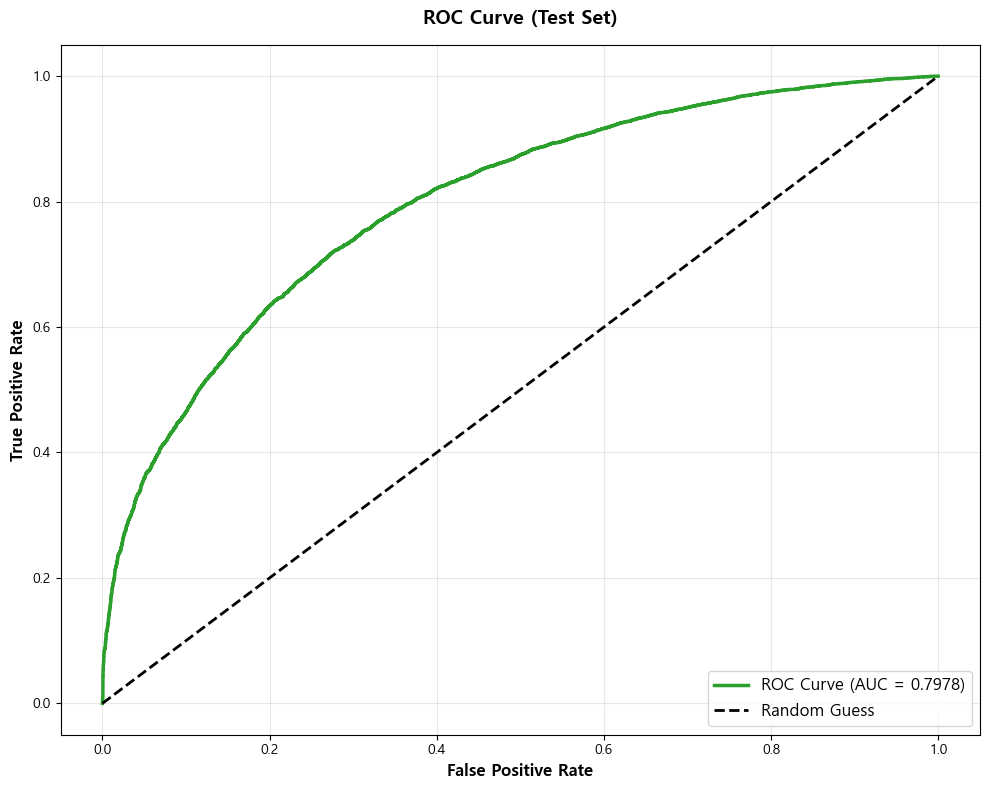

In [41]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#2ca02c', linewidth=2.5, 
         label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Guess')

plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=12)
plt.title('ROC Curve (Test Set)', fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=12, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


---
## 7️⃣ 결론 및 다음 단계


In [ ]:
print("=" * 70)
print("📝 모델링 결과 요약")
print("=" * 70)

print(f"\n✅ 최종 성능 (Test Set):")
print(f"   - Accuracy:  {test_acc:.2%}")
print(f"   - ROC-AUC:   {test_auc:.4f}")
print(f"   - Precision: {test_prec:.4f}")
print(f"   - Recall:    {test_rec:.4f}")
print(f"   - F1-Score:  {test_f1:.4f}")

print(f"\n📊 파생 변수(Feature Engineered) 기여도:")
print(f"   - 전체 파생 변수: {len(all_derived)}개")
print(f"   - Top 10에 포함: {derived_in_top_10}개")
print(f"   - Top 20에 포함: {derived_in_top_20}개")
print(f"\n   💡 팀 파생 변수 카테고리별 (총 30개):")
print(f"      • 교육/경제/혼인: 5개")
print(f"      • 가구/소득/연령: 6개 (⚠️ smoke_avg_per_day 제외)")
print(f"      • 체중/신체활동: 3개")
print(f"      • 식생활/비만/구강: 16개")

print(f"\n🎯 다음 단계:")
print("   1. 하이퍼파라미터 튜닝 (Optuna/GridSearch)")
print("   2. 다른 모델과 비교 (RandomForest, XGBoost)")
print("   3. 앙상블 모델 구축")
print("   4. Cross-Validation으로 안정성 검증")
print("   5. SHAP 값으로 Feature 영향력 분석")

print("\n" + "=" * 70)
print("✅ LightGBM Baseline 모델링 완료!")
print("=" * 70)


📝 모델링 결과 요약

✅ 최종 성능 (Test Set):
   - Accuracy:  72.15%
   - ROC-AUC:   0.7978
   - Precision: 0.7356
   - Recall:    0.7452
   - F1-Score:  0.7404

📊 파생 변수(Feature Engineered) 기여도:
   - 전체 파생 변수: 33개
   - Top 10에 포함: 6개
   - Top 20에 포함: 8개

   💡 주요 파생 변수 카테고리:
      • 교육/경제/혼인: 5개 (교육수준그룹, 경제활동여부, 직업유형, 근로자여부, 혼인안정성)
      • 가구/소득/연령: 7개 (연령대그룹, 1인가구, 소득 관련)
      • 체중/신체활동: 3개 (체중조절방법, 활동점수)
      • 식생활/구강: 16개 (아침빈도, 영양표시, 양치습관 등)

🎯 다음 단계:
   1. 하이퍼파라미터 튜닝 (Optuna/GridSearch)
   2. 다른 모델과 비교 (RandomForest, XGBoost)
   3. 앙상블 모델 구축
   4. Cross-Validation으로 안정성 검증
   5. SHAP 값으로 Feature 영향력 분석

✅ LightGBM Baseline 모델링 완료!
